<font>
<div dir=ltr align=center>
<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2024<br>
<font color=3C99D size=5>
Practical Assignment 5 - V-Value and Q-Value Calculation <br>
<font color=696880 size=4>
Amir Mohammad Fakhimi


# Personal Data

In [1]:
student_number = 403206479
First_Name = 'Emadeddin'
Last_Name = 'Rostamian'

# Objectives
This assignment will guide you through:
1. Implementing V-value and Q-value calculation on an $(n_{row} \times n_{col})$ grid.
2. Verifying the equivalence of $V(s)$ and $Q(s, a)$ using the Bellman equations.
3. Identifying the best action for each state based on Q-values.

# Libraries

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.1 MB/s eta 0:00:00


In [3]:
import numpy as np
from gymnasium import Env, spaces
from enum import Enum
from typing import List, Tuple, Callable
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Problem Definition
Consider an $(n_{row} \times n_{col})$ grid world where an agent can move in four directions: North, South, East, and West. The agent receives a reward for each state it visits, and the goal is to find the optimal policy that maximizes the total reward. The grid world has the following properties:
- The agent receives a living reward of $living_reward$ for each non-terminal state.
- The positive terminal state has a reward of $positive_terminal_reward$.
- The negative terminal state has a reward of $negative_terminal_reward$.
- The agent cannot move into walls (specified by coordinates).
- The discount factor for future rewards is $gamma$.
- The agent can move to the next state with a probability of 1. In other words, the environment is deterministic without any noise.

In [4]:
# Actions: North, South, East, West
class Action(Enum):
    N = 0
    S = 1
    E = 2
    W = 3


# Utility to map Action -> (delta_row, delta_col)
ACTION_DELTAS = {
    Action.N: (-1, 0),
    Action.S: (1, 0),
    Action.E: (0, 1),
    Action.W: (0, -1),
}

# A dictionary to map action to arrow symbols
ACTION_TO_ARROW = {
    Action.N: '↑',
    Action.S: '↓',
    Action.E: '→',
    Action.W: '←',
}

In [5]:
class GridEnv(Env):
    """
    A customizable Grid Environment following the Gymnasium interface.

    Args:
        n_row (int): Number of rows.
        n_col (int): Number of columns.
        positive_terminal (tuple[int,int]): Coordinates of the positive terminal state.
        negative_terminal (tuple[int,int]): Coordinates of the negative terminal state.
        positive_terminal_reward (float): Reward for the positive terminal state.
        negative_terminal_reward (float): Reward for the negative terminal state.
        walls (set[tuple[int,int]]): Set of impassable wall coordinates.
        living_reward (float): The reward for all non-terminal states.

    Observations:
        - Flattened state index in [0, n_row*n_col - 1].

    Actions:
        - Discrete(4) -> [N=0, S=1, E=2, W=3].
    """

    metadata = {'render_modes': ['human']}

    def __init__(
            self,
            n_row=6,
            n_col=5,
            positive_terminal=(2, 3),
            negative_terminal=(3, 2),
            positive_terminal_reward=1.0,
            negative_terminal_reward=-1.0,
            walls=None,
            living_reward=-0.04
    ):
        super().__init__()

        # Store configuration
        self.n_row = n_row
        self.n_col = n_col
        self.POSITIVE_TERMINAL = positive_terminal
        self.NEGATIVE_TERMINAL = negative_terminal
        self.WALLS = walls if walls is not None else set()

        # Initialize the reward matrix
        self.rewards = np.full((self.n_row, self.n_col), living_reward, dtype=np.float32)
        self.rewards[self.POSITIVE_TERMINAL] = positive_terminal_reward
        self.rewards[self.NEGATIVE_TERMINAL] = negative_terminal_reward

        # Define observation space (single integer in [0, n_row*n_col - 1])
        self.observation_space = spaces.Discrete(self.n_row * self.n_col)

        # Define action space (4 discrete actions)
        self.action_space = spaces.Discrete(len(Action))

        # Internal state: (row, col)
        self.state = None

    def reset(self, seed=None, options=None):
        """
        Resets the environment to a valid (row, col) that is not a wall or terminal.

        Args:
            - seed (int): Random seed for reproducibility.
            - options (dict): Additional options for the environment.

        Returns:
            - observation (int): Flattened initial state.
            - info (dict): Additional information.
        """
        super().reset(seed=seed)

        while True:
            row = self.np_random.integers(self.n_row)
            col = self.np_random.integers(self.n_col)

            # Must not be a terminal or wall
            if (row, col) != self.POSITIVE_TERMINAL and (row, col) != self.NEGATIVE_TERMINAL and (
                    row, col) not in self.WALLS:
                self.state = (row, col)
                break

        observation = self._get_observation()
        info = {}
        return observation, info

    def step(self, action):
        """
        Applies the given action in the current state.

        Args:
            - action (int): Action index in [0, 3].

        Returns:
          - observation (int): Flattened next-state
          - reward (float)
          - done (bool)
          - truncated (bool)
          - info (dict)
        """
        row, col = self.state

        # Convert the action integer to an Action enum
        action_enum = Action(action)
        d_row, d_col = ACTION_DELTAS[action_enum]

        # Compute next row/col
        next_row = max(0, min(self.n_row - 1, row + d_row))
        next_col = max(0, min(self.n_col - 1, col + d_col))

        # If it's a wall, stay where you are
        if (next_row, next_col) in self.WALLS:
            next_row, next_col = row, col

        # Compute reward and check if it’s terminal
        reward = self.rewards[next_row, next_col]
        done = (next_row, next_col) == self.POSITIVE_TERMINAL or (next_row, next_col) == self.NEGATIVE_TERMINAL

        # Update internal state
        self.state = (next_row, next_col)

        # No explicit time-limit: truncated = False
        truncated = False
        info = {}

        return self._get_observation(), float(reward), done, truncated, info

    def render(self, mode='human'):
        """
        Render the environment using matplotlib.

        Args:
            - mode (str): The rendering mode.
                - If mode='human', a window with the plot is shown.
                - If mode='rgb_array', this method returns a numpy array of shape (n_row, n_col, 3).

        Returns:
            - np.ndarray or None: The rendered image if mode='rgb_array'.
        """

        # Create an RGB image where each cell is one pixel.
        # Shape: (n_row, n_col, 3) for R, G, B channels
        rgb_image = np.zeros((self.n_row, self.n_col, 3), dtype=np.float32)

        # Define some colors in [0, 1] range (RGB)
        COLOR_WALL = (0.2, 0.2, 0.2)  # dark gray
        COLOR_POSITIVE = (0.0, 1.0, 0.0)  # green
        COLOR_NEGATIVE = (1.0, 0.0, 0.0)  # red
        COLOR_AGENT = (0.6, 0.0, 0.6)  # magenta
        COLOR_EMPTY = (1.0, 1.0, 1.0)  # white

        # Fill in the pixels
        for i in range(self.n_row):
            for j in range(self.n_col):
                if (i, j) in self.WALLS:
                    rgb_image[i, j] = COLOR_WALL
                elif (i, j) == self.POSITIVE_TERMINAL:
                    rgb_image[i, j] = COLOR_POSITIVE
                elif (i, j) == self.NEGATIVE_TERMINAL:
                    rgb_image[i, j] = COLOR_NEGATIVE
                elif (i, j) == self.state:
                    rgb_image[i, j] = COLOR_AGENT
                else:
                    rgb_image[i, j] = COLOR_EMPTY

        if mode == 'rgb_array':
            # Return the raw image array (e.g., to be used by a video recorder)
            return rgb_image

        elif mode == 'human':
            # Show using matplotlib
            plt.figure('GridEnv')
            plt.clf()  # clear figure

            # Display the image
            plt.imshow(rgb_image, origin='upper', interpolation='nearest')
            plt.title('Grid Environment')

            # Optionally draw grid lines
            # Minor ticks at cell boundaries
            plt.xticks(np.arange(-0.5, self.n_col, 1))
            plt.yticks(np.arange(-0.5, self.n_row, 1))
            plt.grid(color='black', linestyle='-', linewidth=1, which='major')

            # Pause briefly so the figure updates
            plt.pause(0.001)
        else:
            raise ValueError(f'Unsupported render mode: {mode}')

    def close(self):
        pass

    def _get_observation(self):
        """
        Returns the flattened state index.

        Returns:
            int: Flattened state index.
        """
        row, column = self.state
        return row * self.n_col + column

# V-Value and Q-Value Calculation
This part involves implementing the value iteration algorithm. This algorithm calculates the optimal state values $V(s)$ by iteratively applying the Bellman update equation.

In [6]:
def next_position(env: GridEnv, i, j, action: Action):
    """
    Predict the next position from (i, j) given an Action,
    mirroring the environment's transition logic without changing its state.
    if new position is a wall, remain where you are.

    Args:
        - env (GridEnv): The grid environment.
        - i (int): Current row.
        - j (int): Current column.
        - action (Action): Action to take.

    Returns:
        - next_i (int): Next row.
        - next_j (int): Next column.
    """
    di, dj = ACTION_DELTAS[action]
    next_i = i + di  # TODO
    next_j = j + dj  # TODO

    # TODO
    if not (0 <= next_i < env.n_row and 0 <= next_j < env.n_col):
      next_i, next_j = i, j

    if (next_i, next_j) in env.WALLS:
      next_i = i
      next_j = j

    return next_i, next_j

## Calculating V-values

In [7]:
def value_iteration(env: GridEnv, gamma: float = 0.9, epsilon: float = 1e-6, max_iterations: int = 1000):
    """
    Perform value iteration until convergence (delta < epsilon).

    Args:
        - env (GridEnv): The grid environment.
        - gamma (float): Discount factor.
        - epsilon (float): Stopping criterion.
        - max_iterations (int): Safety bound on the number of iterations.

    Returns:
        - V (np.ndarray): (n_row, n_col) array of state values.
        - final_iteration (int): The last iteration number (starting from 1).
        - history (List[np.ndarray]): List of V-value snapshots.
    """
    n_row, n_col = env.n_row, env.n_col
    V = np.zeros((n_row, n_col), dtype=np.float32)
    final_iteration = 0
    history = []

    # TODO
    for itr in range(max_iterations):
      delta = 0
      new_V = np.copy(V)
      for i in range(n_row):
        for j in range(n_col):

          if (i, j) in env.WALLS:
            continue
          elif (i, j) == env.POSITIVE_TERMINAL:
            new_V[i,j] = 1
            continue
          elif (i, j) == env.NEGATIVE_TERMINAL:
            new_V[i,j] = -1
            continue

          v = []
          for action in Action:
              next_i, next_j = next_position(env, i, j, action)
              reward = env.rewards[next_i, next_j]
              v.append(reward + gamma * V[next_i, next_j])

          new_V[i, j] = max(v)
          delta = max(delta, abs(new_V[i, j] - V[i, j]))

      V = new_V
      history.append(V.copy())

      if delta < epsilon:
        final_iteration = itr + 1
        print(f"Value iteration converged at iteration {final_iteration}")
        break

    return V, final_iteration + 1, history

## Calculating Q-values
Calculate the Q-values for each state-action pair **without using V-values**.

In [8]:
def q_iteration(env: GridEnv, gamma: float = 0.9, epsilon: float = 1e-6, max_iterations: int = 1000):
    """
    Perform Q-value iteration until convergence (delta < epsilon).

    Args:
        - env (GridEnv): The grid environment.
        - gamma (float): Discount factor.
        - epsilon (float): Stopping criterion.
        - max_iterations (int): Safety bound on the number of iterations.

    Returns:
        - Q (np.ndarray): Q-values of shape (n_row, n_col, num_actions).
        - final_iteration (int): The last iteration number (starting from 1).
        - history (List[np.ndarray]): List of Q-value snapshots.
    """
    n_row, n_col = env.n_row, env.n_col
    num_actions = len(Action)

    Q = np.zeros((n_row, n_col, num_actions), dtype=np.float32)
    final_iteration = 0
    history = []

    # TODO
    for itr in range(max_iterations):
        delta = 0
        new_Q = np.copy(Q)
        for i in range(n_row):
            for j in range(n_col):

              if (i, j) in env.WALLS:
                continue
              elif (i, j) == env.POSITIVE_TERMINAL:
                new_Q[i,j,:] = 1
                continue
              elif (i, j) == env.NEGATIVE_TERMINAL:
                new_Q[i,j,:] = -1
                continue

              for action in Action:
                  next_i, next_j = next_position(env, i, j, action)
                  reward = env.rewards[next_i, next_j]
                  new_Q[i, j, action.value] = reward + gamma * max(Q[next_i, next_j])
                  delta = max(delta, abs(new_Q[i, j, action.value] - Q[i, j, action.value]))
        Q = new_Q
        history.append(Q.copy())
        if delta < epsilon:
            final_iteration = itr + 1
            print(f"Q-value iteration converged at iteration {final_iteration}")
            break

    return Q, final_iteration, history

# Calculations

In [9]:
gamma = 0.9
epsilon = 1e-6
max_iterations = 1000

In [10]:
n_row = 6
n_col = 5
positive_terminal = (2, 3)
negative_terminal = (3, 2)
walls = {(1, 1), (2, 2), (3, 3)}
living_reward = -0.04

In [11]:
env = GridEnv(
    n_row=n_row,
    n_col=n_col,
    positive_terminal=positive_terminal,
    negative_terminal=negative_terminal,
    walls=walls,
    living_reward=living_reward
)

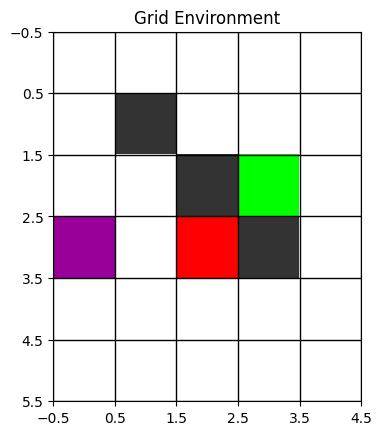

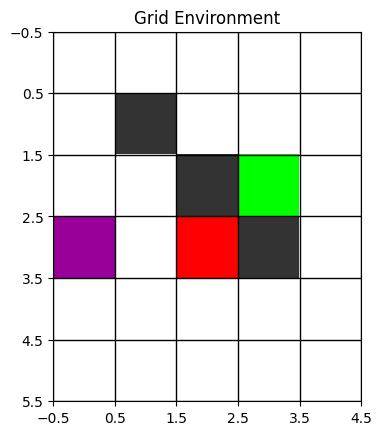

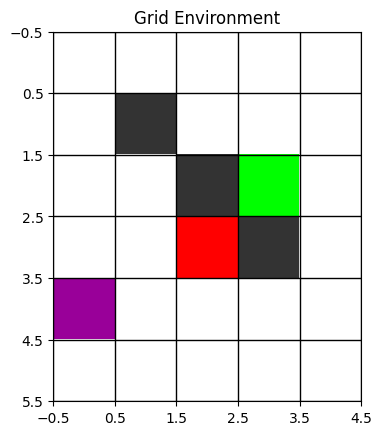

In [12]:
# Run a short random episode to visualize the environment
# Here render method will be called

obs, info = env.reset()
for _ in range(3):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        print('Episode finished!')
        obs, info = env.reset()

In [13]:
V, V_iteration, V_history = value_iteration(env, gamma=gamma, epsilon=epsilon, max_iterations=max_iterations)

Value iteration converged at iteration 10


In [14]:
print('Final V-values:')
print(V)

Final V-values:
[[ 1.1090299  1.2766999  1.4629999  1.67       1.4629999]
 [ 0.9581269  0.         1.67       1.9        1.67     ]
 [ 0.8223142  0.7000828  0.         1.         1.9      ]
 [ 0.7000828  0.8223142 -1.         0.         1.67     ]
 [ 0.8223142  0.9581269  1.1090299  1.2766999  1.4629999]
 [ 0.7000828  0.8223142  0.9581269  1.1090299  1.2766999]]


In [15]:
Q, Q_iteration, Q_history = q_iteration(env, gamma=gamma, epsilon=epsilon, max_iterations=max_iterations)

Q-value iteration converged at iteration 11


In [16]:
print('Final Q-values:')
print(Q)

Final Q-values:
[[[ 0.9581269  0.8223142  1.1090299  0.9581269]
  [ 1.1090299  1.1090299  1.2766999  0.9581269]
  [ 1.2766999  1.4629999  1.4629999  1.1090299]
  [ 1.4629999  1.67       1.2766999  1.2766999]
  [ 1.2766999  1.4629999  1.2766999  1.4629999]]

 [[ 0.9581269  0.7000828  0.8223142  0.8223142]
  [ 0.         0.         0.         0.       ]
  [ 1.2766999  1.4629999  1.67       1.4629999]
  [ 1.4629999  1.9        1.4629999  1.4629999]
  [ 1.2766999  1.67       1.4629999  1.67     ]]

 [[ 0.8223142  0.5900745  0.5900745  0.7000828]
  [ 0.5900745  0.7000828  0.5900745  0.7000828]
  [ 0.         0.         0.         0.       ]
  [ 1.         1.         1.         1.       ]
  [ 1.4629999  1.4629999  1.67       1.9      ]]

 [[ 0.7000828  0.7000828  0.7000828  0.5900745]
  [ 0.5900745  0.8223142 -1.9        0.5900745]
  [-1.        -1.        -1.        -1.       ]
  [ 0.         0.         0.         0.       ]
  [ 1.67       1.2766999  1.4629999  1.4629999]]

 [[ 0.5900745  0

# Verification
This part verifies that the state values $V(s)$ and Q-values $Q(s, a)$ satisfy the Bellman equations.

In [17]:
def verify_bellman_equations(env: GridEnv, V: np.ndarray, Q: np.ndarray):
    """
    Verifies the Bellman equations for V-values and Q-values:
    Checks that V(s) = max_a Q(s, a) for each non-terminal, non-wall state.

    Args:
        - env (GridEnv): The grid environment.
        - V (np.ndarray): State values of shape (n_row, n_col).
        - Q (np.ndarray): Q-values of shape (n_row, n_col, num_actions).

    Returns:
        None
    """
    for i in range(env.n_row):
        for j in range(env.n_col):
            # skip walls and terminal states
            if (i, j) in env.WALLS:
                continue
            if (i, j) == env.POSITIVE_TERMINAL or (i, j) == env.NEGATIVE_TERMINAL:
                continue

            v_value = V[i, j]
            max_q = np.max(Q[i, j, :])
            assert np.isclose(v_value, max_q), (
                f'Bellman verification failed at ({i}, {j}): '
                f'V={v_value} vs. max_a Q={max_q}'
            )

    print('Verification passed: V(s) = max_a Q(s, a) for all valid states.')

In [18]:
verify_bellman_equations(env, V, Q)

Verification passed: V(s) = max_a Q(s, a) for all valid states.


# Find the Optimal Policy
This part finds the best action for each state based on Q-values.

In [44]:
def get_optimal_policy_indices(env: GridEnv, Q: np.ndarray):
    """
    Extracts the optimal policy (action indices) from Q-values.

    Args:
        - env (GridEnv): The GridEnv (with env.n_row, env.n_col, env.WALLS, etc.).
        - Q (np.ndarray): A 3D array of shape (n_row, n_col, num_actions) with Q-values.

    Returns:
        - policy_indices (np.ndarray):
            A 2D array of shape (n_row, n_col). Each cell contains:
              - The best action index [0, 3] for normal states;
              - -1 for walls or terminal states.
    """
    n_row, n_col, num_actions = Q.shape
    policy_indices = np.full((n_row, n_col), -1, dtype=int)

    # TODO
    for row in range(n_row):
        for col in range(n_col):
            if (row, col) in env.WALLS or (row, col) == env.POSITIVE_TERMINAL or (row, col) == env.NEGATIVE_TERMINAL:
                continue
            best_action = np.argmax(Q[row, col, :])
            policy_indices[row, col] = best_action

    return policy_indices

In [45]:
def get_policy_arrows(env: GridEnv, policy_indices: np.ndarray):
    """
    Converts policy indices into a 2D array of symbols:
      - Walls -> '#'
      - Positive terminal -> '+'
      - Negative terminal -> '-'
      - Normal states -> one of { '↑','↓','→','←' }.

    Args:
        - env: The GridEnv (with env.n_row, env.n_col, env.WALLS, etc.).
        - policy_indices (np.ndarray): 2D array (n_row, n_col) with best action or -1.

    Returns:
        policy_arrows (np.ndarray): 2D array (n_row, n_col) of strings.
    """
    n_row, n_col = policy_indices.shape
    policy_arrows = np.full((n_row, n_col), '', dtype=object)

    for i in range(n_row):
        for j in range(n_col):
            # Check if it's a wall or terminal by indexing -1 or checking env
            if policy_indices[i, j] == -1:
                if (i, j) in env.WALLS:
                    policy_arrows[i, j] = '#'
                elif (i, j) == env.POSITIVE_TERMINAL:
                    policy_arrows[i, j] = '+'
                elif (i, j) == env.NEGATIVE_TERMINAL:
                    policy_arrows[i, j] = '-'
                else:
                    # If -1 but not a known special cell, just leave blank or mark as '?'
                    policy_arrows[i, j] = '?'
            else:
                # Normal state: map to arrow
                best_action = policy_indices[i, j]
                policy_arrows[i, j] = ACTION_TO_ARROW.get(Action(best_action), '?')

    return policy_arrows


In [46]:
optimal_policy_indices = get_optimal_policy_indices(env, Q)
optimal_policy = get_policy_arrows(env, optimal_policy_indices)

In [47]:
print('Optimal Policy:')
print(optimal_policy)

Optimal Policy:
[['→' '→' '↓' '↓' '↓']
 ['↑' '#' '→' '↓' '↓']
 ['↑' '↓' '#' '+' '←']
 ['↑' '↓' '-' '#' '↑']
 ['→' '→' '→' '→' '↑']
 ['↑' '↑' '↑' '↑' '↑']]


# Visualization

## V-values with Optimal Policy

In [48]:
def plot_v_values(env: GridEnv, ax: matplotlib.axes.Axes, V: np.ndarray, optimal_policy: np.ndarray = None,
                  iteration_label='Final', add_colorbar: bool = True):
    """
    Visualizes the state values (V) on a grid, overlaying:
    - Numeric values of V
    - An arrow for the optimal policy of each state (if provided in optimal_policy)
    - Special colors/labels for walls and terminal states

    Args:
        - env (GridEnv): The grid environment (accessing env.n_row, env.n_col, env.WALLS, etc.).
        - ax (matplotlib.axes.Axes): Matplotlib axis to plot on.
        - V (np.ndarray): A 2D array of shape (n_row, n_col) containing V-values.
        - optimal_policy (np.ndarray): A 2D array of shape (n_row, n_col) with the optimal policy index per cell
                                   (0=Up, 1=Down, 2=Right, 3=Left).
                                   If None, no action arrows are displayed.
        - iteration_label (str or int): Displayed in the title (e.g., '20' or 'Converged').
        - add_colorbar (bool): Whether to add a colorbar to the plot.

    Returns:
        None
    """
    ax.set_title(f'V-values with Optimal Policy ({iteration_label})', fontsize=14)
    n_row, n_col = V.shape
    cax = ax.imshow(V, cmap='viridis', interpolation='nearest', origin='upper')

    if add_colorbar:
        plt.colorbar(cax, ax=ax, label='V-value', shrink=0.8, aspect=30, pad=0.02)

    # Annotate each cell
    for i in range(n_row):
        for j in range(n_col):
            current_state = (i, j)
            value = V[i, j]

            # Determine if cell is a wall or terminal
            if current_state in env.WALLS:
                # Wall: Draw a gray rectangle or label
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='gray', alpha=0.5))
                text_label = 'Wall'
            elif current_state == env.POSITIVE_TERMINAL:
                # Positive terminal (green)
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='green', alpha=0.5))
                text_label = 'End\n(+)'
            elif current_state == env.NEGATIVE_TERMINAL:
                # Negative terminal (red)
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='red', alpha=0.5))
                text_label = 'End\n(-)'
            else:
                # Normal cell
                if optimal_policy is not None:
                    # Map the best action index to an arrow
                    arrow_idx = optimal_policy[i, j]
                    arrow_symbol = ACTION_TO_ARROW.get(Action(arrow_idx), '')
                    text_label = f'{value:.2f}\n{arrow_symbol}'
                else:
                    # Just show the value if no best_actions
                    text_label = f'{value:.2f}'

            # Place the text in the center of the cell
            ax.text(j, i, text_label, ha='center', va='center', fontsize=9, color='black' if value >= 0 else 'white')

    # Adjust axis ticks and labels
    ax.set_xticks(range(n_col))
    ax.set_yticks(range(n_row))
    ax.set_xticklabels(range(n_col))
    ax.set_yticklabels(range(n_row))

    # Set limits so cells line up with ticks
    ax.set_xlim(-0.5, n_col - 0.5)
    ax.set_ylim(n_row - 0.5, -0.5)

    # ax.set_aspect('equal')

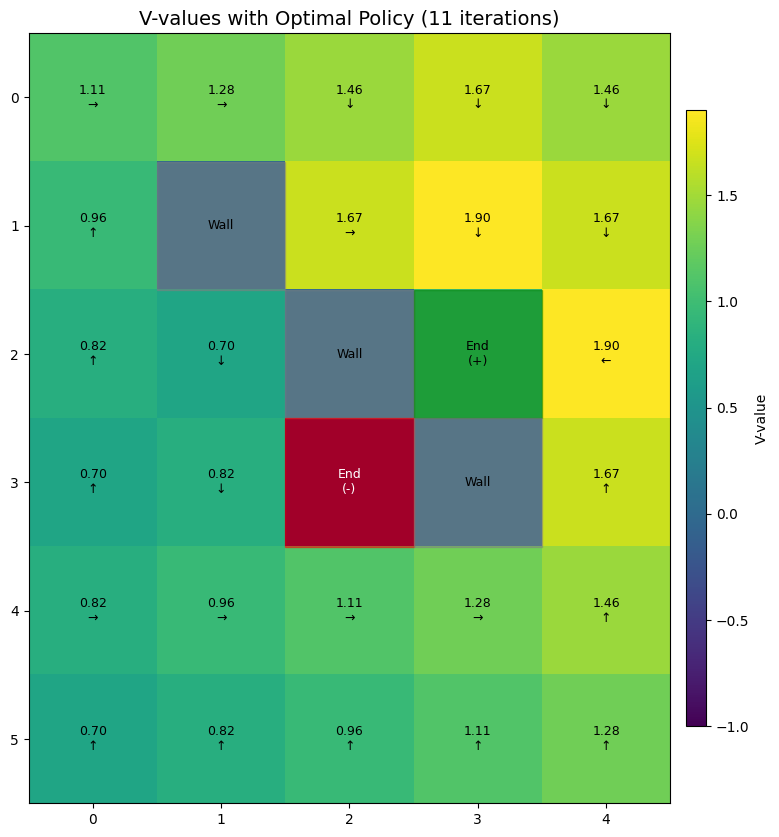

In [49]:
_, ax = plt.subplots(figsize=(10, 10))
plot_v_values(env, ax, V, optimal_policy=optimal_policy_indices, iteration_label=f'{V_iteration} iterations')
plt.show()

## Q-values with Optimal Policy

In [50]:
def plot_q_values(env: GridEnv, ax: matplotlib.axes.Axes, Q: np.ndarray, optimal_policy: np.ndarray = None,
                  iteration_label='Final', add_colorbar: bool = True):
    """
    Visualizes Q-values in each cell by dividing it into triangles
    (one triangle per action). The color of each triangle reflects Q(s,a).

    Walls and terminal states are highlighted separately.
    If optimal_policy is provided, an arrow is drawn indicating the optimal action.

    Args:
        - env (GridEnv): The grid environment (accessing env.n_row, env.n_col, env.WALLS, etc.).
        - ax (matplotlib.axes.Axes): The Matplotlib axis to draw on.
        - Q (np.ndarray): 3D array (n_row, n_col, num_actions) of Q-values.
        - optimal_policy (np.ndarray or None): 2D array (n_row, n_col) of optimal action indices (0..3).
        - iteration_label (str or int): Label for the plot title (e.g. '20', 'Converged', etc.).
        - add_colorbar (bool): Whether to add a colorbar legend.

    Returns:
        None
    """
    n_row, n_col, _ = Q.shape

    ax.set_xlim(-0.5, n_col - 0.5)
    ax.set_ylim(-0.5, n_row - 0.5)

    ax.set_title(f'Q-values with Optimal Policy ({iteration_label})', fontsize=14)

    # Define the 4 possible actions (consistent with Q's 3rd dimension)
    # and the triangle coordinates relative to cell center
    actions = [Action.N, Action.S, Action.E, Action.W]
    directions = {
        Action.N: [(0, 0), (-0.5, -0.5), (0.5, -0.5)],
        Action.S: [(0, 0), (-0.5, 0.5), (0.5, 0.5)],
        Action.E: [(0, 0), (0.5, -0.5), (0.5, 0.5)],
        Action.W: [(0, 0), (-0.5, -0.5), (-0.5, 0.5)]
    }

    # Create a color map for Q-values
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=Q.min(), vmax=Q.max())

    # For drawing the optimal policy arrow at the cell center
    arrow_positions = {
        Action.N: (0, -0.43),
        Action.S: (0, 0.43),
        Action.E: (0.35, 0.1),
        Action.W: (-0.35, 0.1)
    }

    for i in range(n_row):
        for j in range(n_col):
            current_state = (i, j)

            # Walls / Terminal states
            if current_state in env.WALLS:
                # Wall cell
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='gray', alpha=0.5))
                ax.text(j, i, 'Wall', ha='center', va='center', fontsize=9, color='black')
                continue
            elif current_state == env.POSITIVE_TERMINAL:
                # Positive terminal (green)
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='green', alpha=0.5))
                rew_str = f'{env.rewards[i, j]:.2f}'
                ax.text(j, i, f'{rew_str}\nPositive\nEnd', ha='center', va='center', fontsize=9, color='black')
                continue
            elif current_state == env.NEGATIVE_TERMINAL:
                # Negative terminal (red)
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='red', alpha=0.5))
                rew_str = f'{env.rewards[i, j]:.2f}'
                ax.text(j, i, f'{rew_str}\nNegative\nEnd', ha='center', va='center', fontsize=9, color='white')
                continue

            # Normal cells: draw 4 triangles (one per action)
            for a_idx, action in enumerate(actions):
                q_value = Q[i, j, a_idx]

                # Build the triangle coords around (j, i) (the center of cell)
                tri_coords = [(j + x, i + y) for (x, y) in directions[action]]
                color = cmap(norm(q_value))

                # Draw the triangle
                polygon = plt.Polygon(tri_coords, closed=True, edgecolor='black', facecolor=color, alpha=0.8)
                ax.add_patch(polygon)

                # Place Q-value text near triangle center
                x_center = np.mean([x for x, _ in tri_coords])
                y_center = np.mean([y for _, y in tri_coords])
                ax.text(x_center, y_center, f'{q_value:.2f}', ha='center', va='center', fontsize=8,
                        color='black' if q_value >= 0 else 'white')

            # Draw best-action arrow, if provided
            if optimal_policy is not None:
                best_a_idx = optimal_policy[i, j]

                # If -1 => wall/terminal => skip
                if 0 <= best_a_idx < len(actions):
                    best_action = actions[best_a_idx]
                    dx, dy = arrow_positions[best_action]
                    arrow_char = ACTION_TO_ARROW.get(best_action, '?')

                    # The center of the cell is (j, i)
                    arrow_x = j + dx
                    arrow_y = i + dy
                    ax.text(arrow_x, arrow_y, arrow_char, ha='center', va='center', fontsize=10, color='blue')

    # Optional colorbar for Q-value scale
    if add_colorbar:
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Q-value', shrink=0.8, aspect=30,
                     pad=0.02)

    # Set up axis ticks
    ax.set_xticks(range(n_col))
    ax.set_yticks(range(n_row))
    ax.set_xticklabels(range(n_col))
    ax.set_yticklabels(range(n_row))

    ax.invert_yaxis()
    ax.set_aspect('equal')

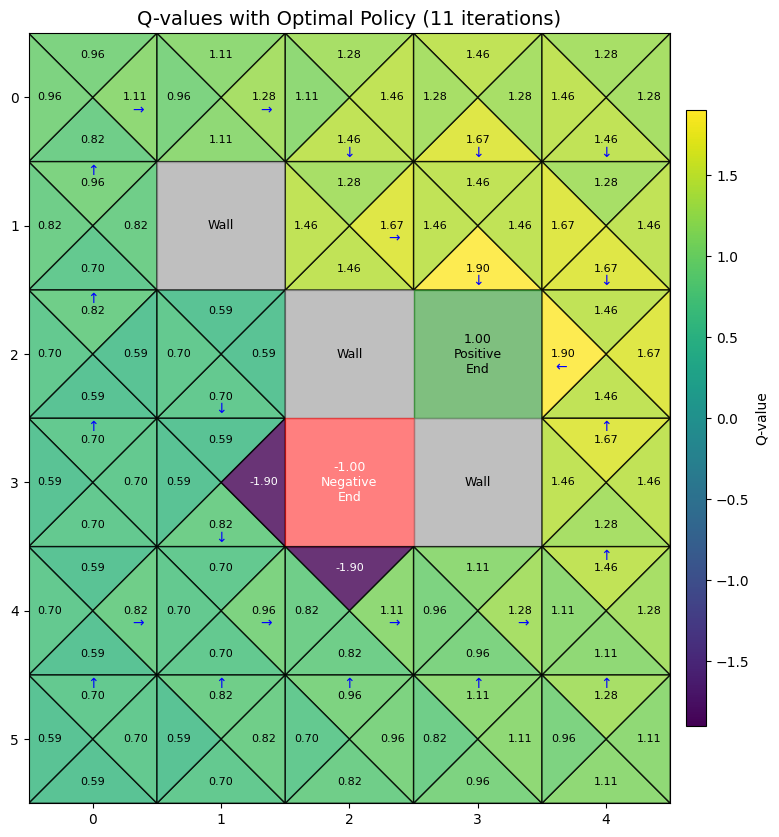

In [51]:
_, ax = plt.subplots(figsize=(10, 10))
plot_q_values(env, ax, Q, optimal_policy=optimal_policy_indices, iteration_label=f'{Q_iteration} iterations')
plt.show()

## Animated Visualization

In [52]:
def animated_visualization(env: GridEnv, history: List[np.ndarray], update_function: Callable, all_iterations: int,
                           save_title: str, fig_size: Tuple[int, int] = (10, 10)):
    """
    Creates an animation of V-value progression over iterations with optimal policy arrows.

    Args:
        env (GridEnv): The grid environment (accessing env.n_row, env.n_col, env.WALLS, etc.).
        history (List[np.ndarray]): History of V-values across iterations.
        update_function (function): Function to update the plot at each frame.
        all_iterations (int): Total number of iterations.
        save_title (str): Title of the file to save the animation (GIF format).
        fig_size (tuple[int, int]): Size of the figure (width, height).

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=fig_size)
    is_first = True

    def update(frame):
        nonlocal is_first

        ax.clear()
        update_function(env, ax, history[frame], None, f'{frame + 1}/{all_iterations}', add_colorbar=is_first)
        is_first = False

    ani = animation.FuncAnimation(fig, update, frames=len(history), repeat=True)
    ani.save(save_title, writer='pillow')
    plt.show()

### V-values Animation

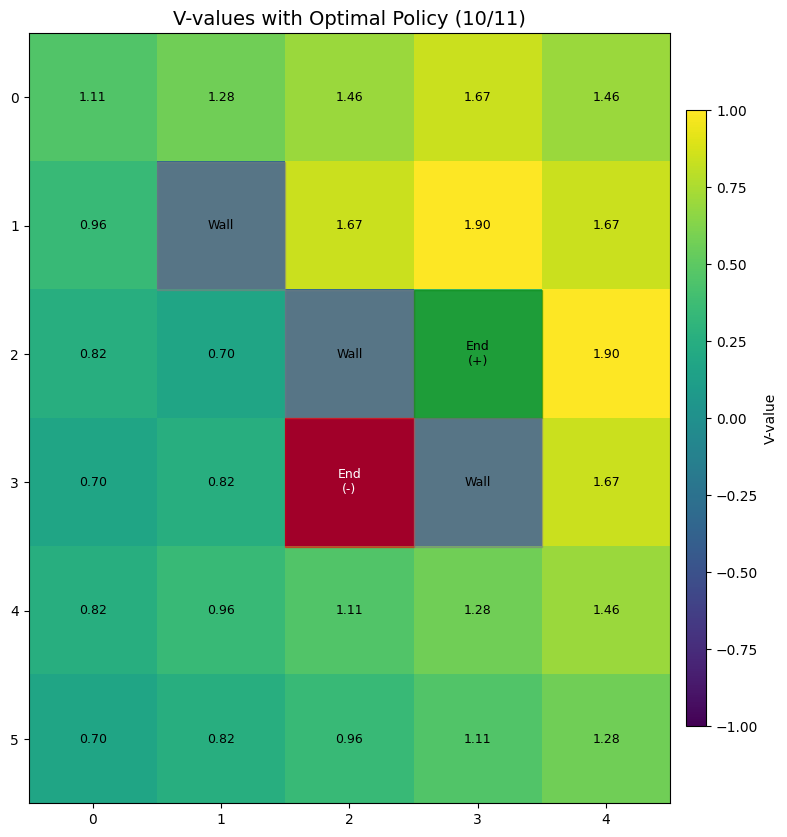

In [53]:
animated_visualization(env, V_history, plot_v_values, V_iteration, 'v_values_animation.gif')

### Q-values Animation

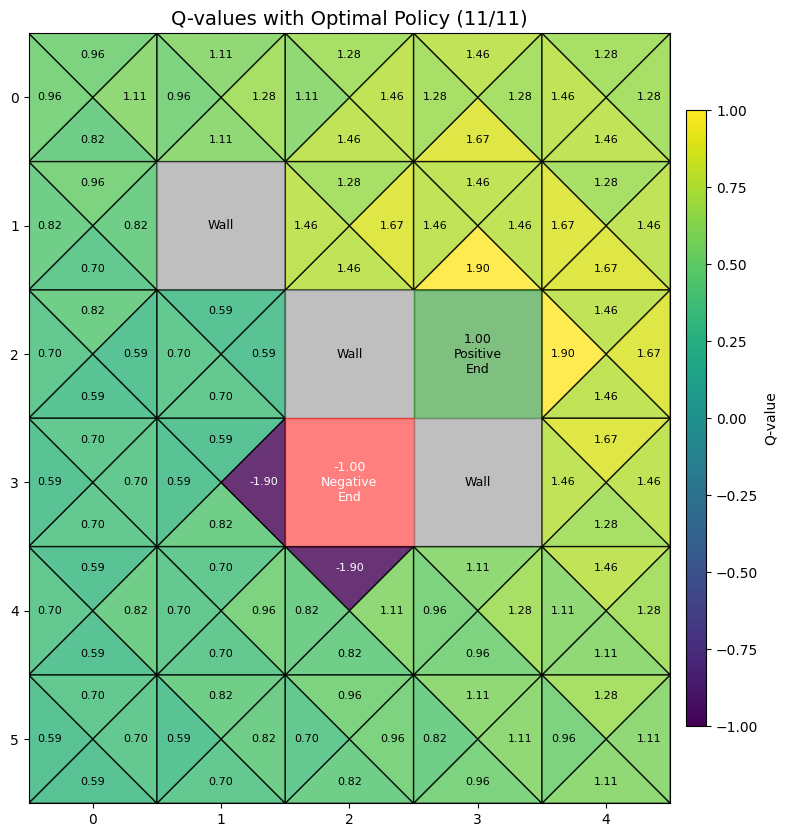

In [54]:
animated_visualization(env, Q_history, plot_q_values, Q_iteration, 'q_values_animation.gif')

# Test
**Output of each cell should be same as provided outputs.**

## Define new parameters

In [55]:
gamma = 0.95
epsilon = 1e-5
max_iterations = 100

In [56]:
n_row = 10
n_col = 11
positive_terminal = (7, 5)
negative_terminal = (4, 4)
walls = {(3, 3), (4, 3), (5, 3)}
living_reward = -0.06

In [57]:
env = GridEnv(
    n_row=n_row,
    n_col=n_col,
    positive_terminal=positive_terminal,
    negative_terminal=negative_terminal,
    walls=walls,
    living_reward=living_reward
)

## Calculations

In [58]:
V, V_iteration, V_history = value_iteration(env, gamma=gamma, epsilon=epsilon, max_iterations=max_iterations)

Value iteration converged at iteration 14


In [59]:
Q, Q_iteration, Q_history = q_iteration(env, gamma=gamma, epsilon=epsilon, max_iterations=max_iterations)

Q-value iteration converged at iteration 15


## Verification

In [60]:
verify_bellman_equations(env, V, Q)

Verification passed: V(s) = max_a Q(s, a) for all valid states.


## Find the Optimal Policy

In [61]:
optimal_policy_indices = get_optimal_policy_indices(env, Q)
optimal_policy = get_policy_arrows(env, optimal_policy_indices)

In [62]:
print('Optimal Policy:')
print(optimal_policy)

Optimal Policy:
[['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '→' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '#' '→' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '#' '-' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '#' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '+' '←' '←' '←' '←' '←']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑']]


## Visualization

### V-values with Optimal Policy

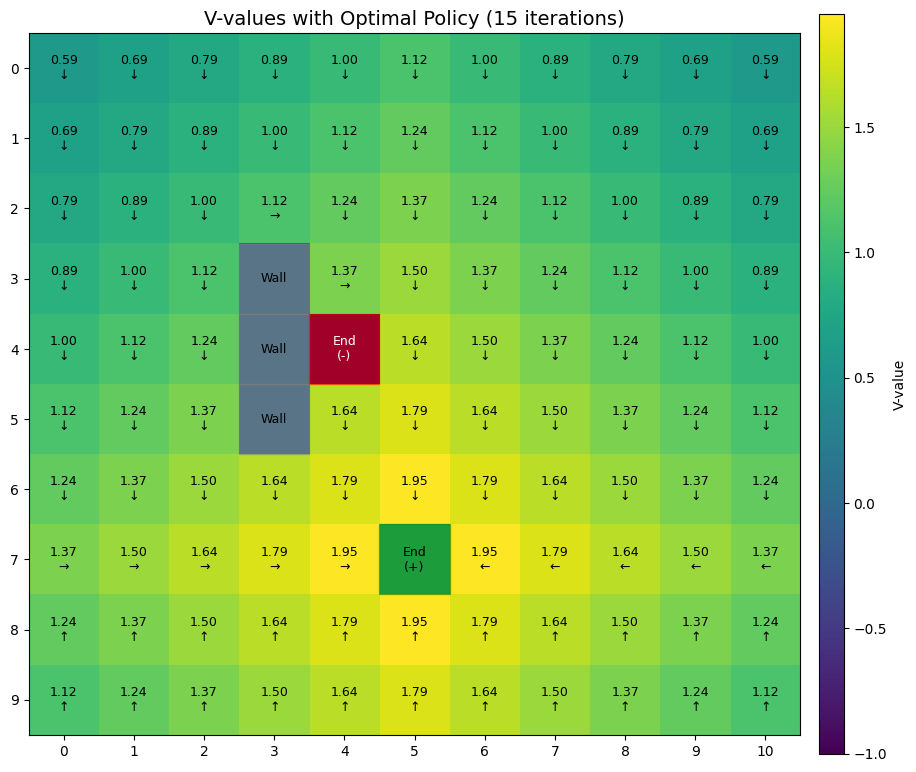

In [63]:
_, ax = plt.subplots(figsize=(12, 12))
plot_v_values(env, ax, V, optimal_policy=optimal_policy_indices, iteration_label=f'{V_iteration} iterations')
plt.show()

### Animated V-values

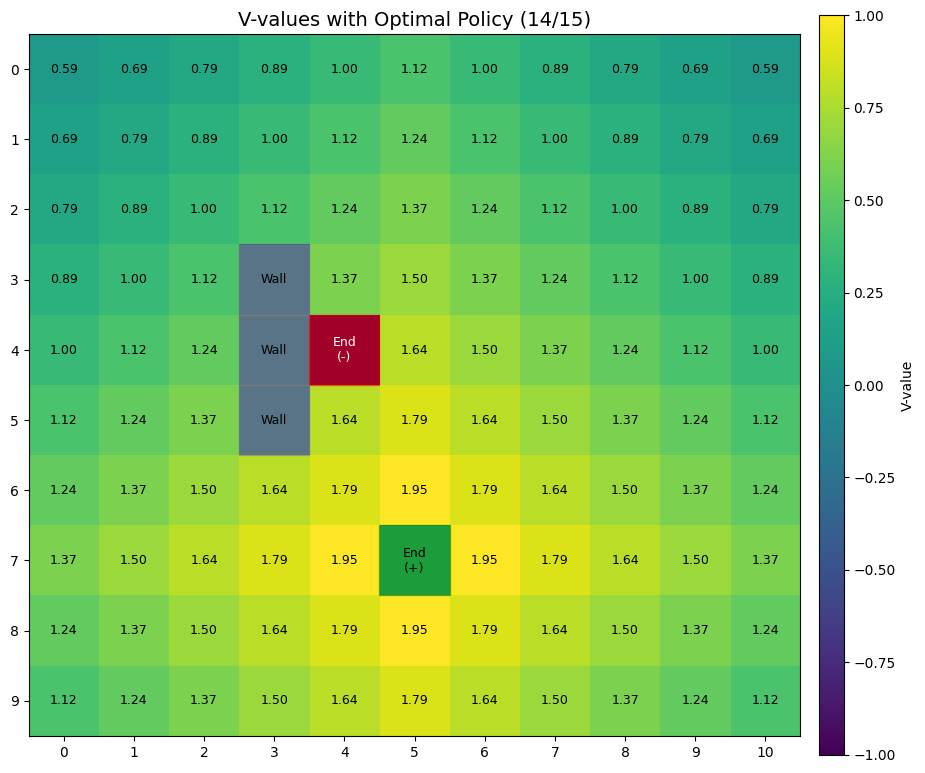

In [64]:
animated_visualization(env, V_history, plot_v_values, V_iteration, 'test_v_values_animation.gif', fig_size=(12, 12))

### Q-values with Optimal Policy

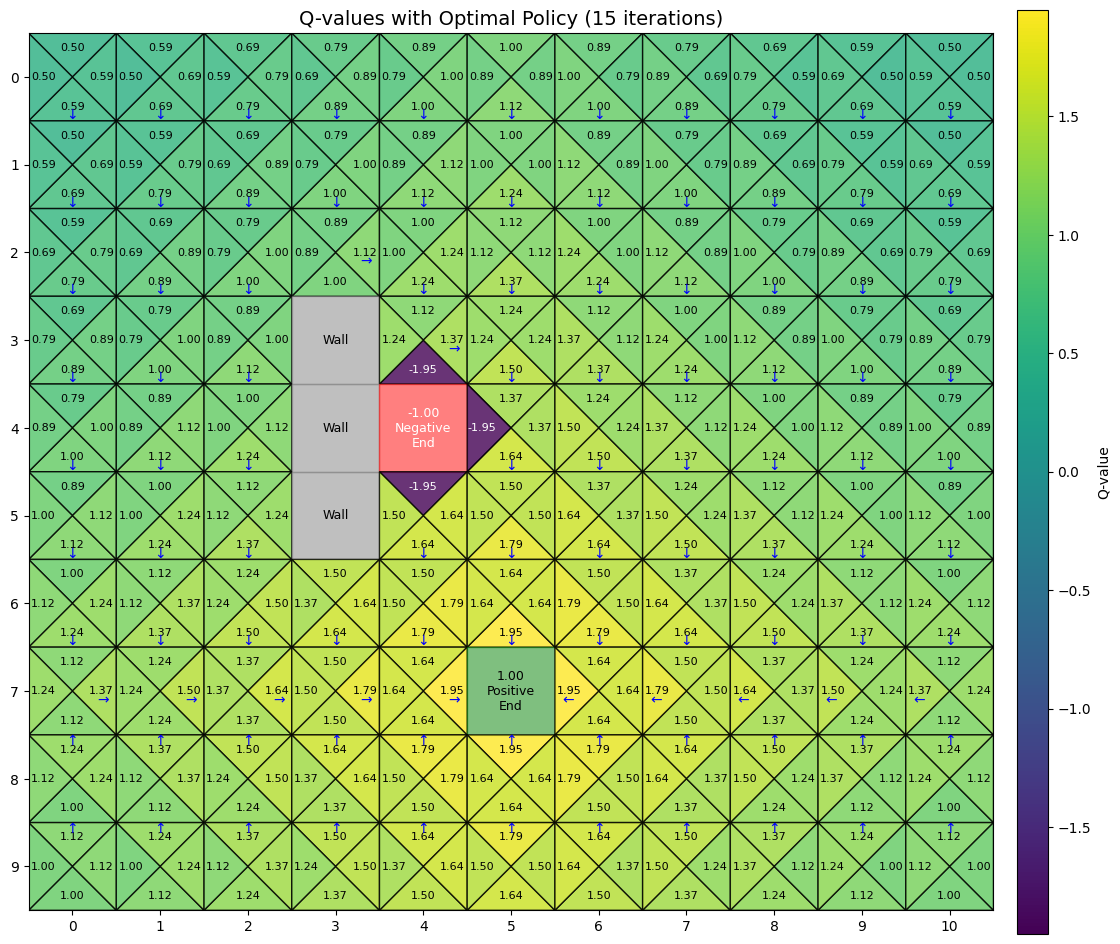

In [65]:
_, ax = plt.subplots(figsize=(15, 15))
plot_q_values(env, ax, Q, optimal_policy=optimal_policy_indices, iteration_label=f'{Q_iteration} iterations')
plt.show()

### Animated Q-values

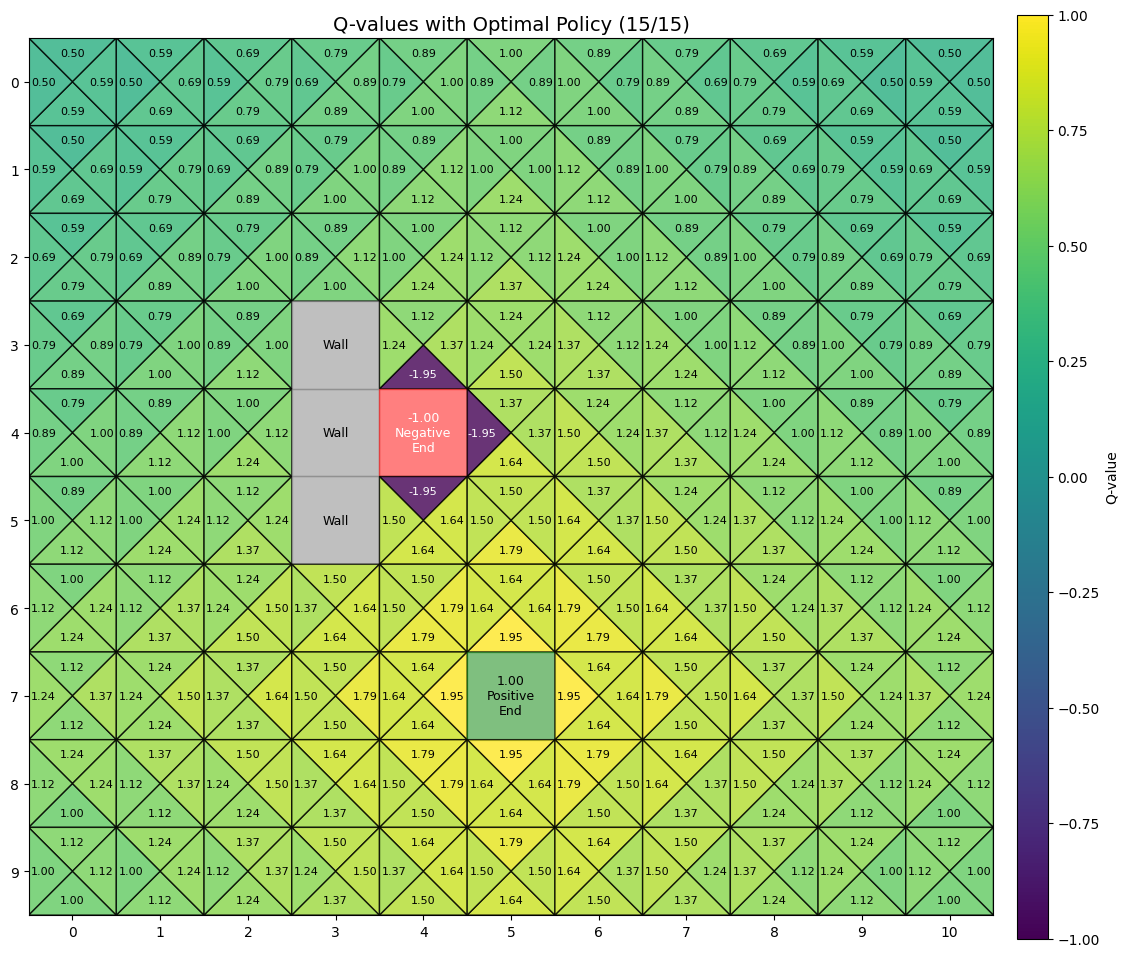

In [66]:
animated_visualization(env, Q_history, plot_q_values, Q_iteration, 'test_q_values_animation.gif', fig_size=(15, 15))